#  Unsupervised learning addition model with generator  -  using loopy encoder and decoder method

Author: S. Menary [sbmenary@gmail.com]

Date: 15/6/2023  (last update: 15/6/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $\sum_{i=1}^N A_i$ for a configurable number $N$ of integers $A_i\in\mathbb{Z}$, and the output is a set of logits representing the probability of each token in the output sequence. Integers may have a configurable number of digits. At inference time, chains of text are generated auto-regressively until the terminate-sequence token is reached. The loss function is a sparse categorical entropy.

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, os, sys

##  Import entire pypi packages
import tensorflow as tf

##  Remove tensorflow INFO messages
tf.get_logger().setLevel('WARNING')

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import AdamW
from mathsformer import config, data, transformers, utils
from mathsformer import selfsupervised_learning_addition_model_backend as backend


## 1. Configure run

Set configuration variables for entire program

In [2]:
##==============================##
##   Set custom config values   ##
##==============================##

custom_config = {
    "global" : {
        "base_seed"        : -1,
        "working_dir"      : "SSL_loopy_enc_dec_notebook_[global>problem_tag]_embed[model>ndim_embedding]_enc_[model>encoder>num_blocks]blocks_[model>encoder>num_loops]loops_width[model>encoder>ndim_ff_hidden]_dec_[model>decoder>num_blocks]blocks_[model>decoder>num_loops]loops_width[model>decoder>ndim_ff_hidden]_post[model>post_decoder>num_layers]_width[model>post_decoder>ndim]_idem[model>idempotent_size]_[date]",
        "problem_tag"      : "int1234_num1245",
        "log_lvl_iostream" : logging.INFO,
        "log_lvl_fstream"  : logging.DEBUG,
    },
    "data" : {
        "train_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [1, 2, 4, 5],
            "batch_size"       : 32,
            "num_batches"      : 2000,
            "gen_base_seed"    : 101,
            "gen_reproducible" : False, 
        },
        "val_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [3],
            "batch_size"       : 32,
            "num_batches"      : 50,
            "gen_base_seed"    : 102,
            "gen_reproducible" : True,
        },
        "test_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [6],
            "batch_size"       : 32,
            "num_batches"      : 100,
            "gen_base_seed"    : 103,
            "gen_reproducible" : True,
        },
        "characters"              : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"               : 'M',
        "seq_start_char"          : 'B',
        "seq_end_char"            : 'E',
        "negative_char"           : 'N',
        "dtype"                   : "int32",
    },
    "model" : {
        "load_pretrained_model" : None,
        "name"                  : "mathsformer_LLM",
        "dtype"                 : "float32",
        "dropout"               : 0.1,
        "jit_compile"           : False,
        "use_old_loss"          : True,
        "optimizer"             : AdamW,
        "optimizer_args"        : {"learning_rate":1e-4, "weight_decay":2e-2},
        "idempotent_size"       : -1,
        "positional_encoding" : {
            "num_freqs"         : 64,
            "min_period"        : 4,
            "max_period"        : 1000,
            "learnable"         : True,
        },
        "ndim_embedding"        : 128,
        "comb_type"             : 'average',
        "pre_encoder"           : {
            "num_layers"        : -1,
            "ndim"              : 256,
            "skip_connect"      : True,
        },
        "pre_decoder" : {
            "num_layers"        : -1,
            "ndim"              : 256,
            "skip_connect"      : True,
        },
        "encoder" : {
            "num_blocks"        : 2,
            "num_loops"         : 5,
            "num_heads"         : 8,
            "ndim"              : 128,
            "ndim_att_hidden"   : 128,
            "ndim_ff_hidden"    : 512,
            "skip_connect"      : True,
        },
        "decoder" : {
            "num_blocks"        : 2,
            "num_loops"         : 1,
            "num_heads"         : 8,
            "ndim"              : 128,
            "ndim_att_hidden"   : 128,
            "ndim_ff_hidden"    : 512,
            "skip_connect"      : True,
        },
        "post_decoder" : {
            "num_layers"        : 3,
            "ndim"              : 512,
        },
    },
    "training" : {
        "train"          : True,
        "max_epochs"     : 100000,
        "log_after_epoch" : {
            "do"          : True,
            "log_lvl"     : logging.DEBUG,
        },
        "early_stopping" : {
            "do"                   : False,
            "patience"             : 4,
            "monitor"              : "loss",
            "mode"                 : "min",
            "restore_best_weights" : True,
        },
        "model_checkpoint" : {
            "do"       : True,
            "filename" : "model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras",
        },
        "layer_weights_record" : {
            "do"               : True,
            "batch_frequency"  : 2000,
            "recursive"        : True,
        },
        "adaptive_learning_rate" : {
            "do"                 : True,
            "decay_factor"       : 0.2,
            "monitor"            : "loss",
            "mode"               : "min",
            "patience"           : 3,
            "log_lvl"            : logging.DEBUG,
        },
        "print_tables_during_training" : {
            "do"        : True,
            "num_print" : 10,
        },
    },
    "evaluate" : {
        "num_print"            : 50,
        "save_model"           : True,
        "plot_weights"         : False,
        "plot_training_curves" : True,
    },
}


In [3]:
##===================================##
##   Load and validate full config   ##
##===================================##

##  Create config object containing default values
cfg = config.Config(backend.DEFAULT_CONFIG)

##  Override with custom values
cfg.load_dict(custom_config)

##  Validate config
backend.validate_config(cfg)

##  Print success
print(utils.fancy_message(f"Config created"))

##  For convenience, split configs for different sections
cfg_global   = cfg["global"  ]
cfg_data     = cfg["data"    ]
cfg_model    = cfg["model"   ]
cfg_training = cfg["training"]
cfg_evaluate = cfg["evaluate"]


===   Config created   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = utils.initialise_program(
    "unsupervised_learning_addition_model_generator (notebook)", 
    working_dir       = cfg_global["working_dir"], 
    cfg               = cfg,
    base_seed         = cfg_global["base_seed"],
    log_lvl_iostream  = cfg_global["log_lvl_iostream"],
    log_lvl_fstream   = cfg_global["log_lvl_fstream" ],
)


===   Working directory created at SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idemm1_2023_06_25_v2   ===
   INFO initialise_logging: Begin logging on 2023-06-25 at 21:01:19
   INFO initialise_program: Program description: unsupervised_learning_addition_model_generator (notebook)
   INFO initialise_program: Working directory: SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idemm1_2023_06_25_v2
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                     

   INFO log_versions:                                 platformdirs.version  |  3.6.0
   INFO log_versions:                                       prompt_toolkit  |  3.0.38
   INFO log_versions:                                               psutil  |  5.9.5
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.5
   INFO log_versions:                                             pygments  |  2.15.1
   INFO log_versions:                                            pyparsing  |  3.1.0
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.31.0
   INFO log_versions:                                 requests

   INFO initialise_program: Registered config value data > val_data > num_ints: [3]
   INFO initialise_program: Registered config value data > val_data > batch_size: 32
   INFO initialise_program: Registered config value data > val_data > num_batches: 50
   INFO initialise_program: Registered config value data > val_data > gen_base_seed: 102
   INFO initialise_program: Registered config value data > val_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > test_data > int_lengths: [1, 2, 3, 4]
   INFO initialise_program: Registered config value data > test_data > num_ints: [6]
   INFO initialise_program: Registered config value data > test_data > batch_size: 32
   INFO initialise_program: Registered config value data > test_data > num_batches: 100
   INFO initialise_program: Registered config value data > test_data > gen_base_seed: 103
   INFO initialise_program: Registered config value data > test_data > gen_reproducible: True
   INFO initialise_prog

##  3. Create training data

###  Create tokeniser

Tokeniser object handles the transformation from strings to tensors and back again

In [5]:
##======================##
##   Create tokeniser   ##
##======================##

token_transform = data.TokenTransform.from_dictionary(cfg_data)
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


###  Create data generators for train/val/test sets

Data generators create tensor inputs/outputs for the model on-the-fly


In [6]:
##============================##
##   Create data generators   ##
##============================##

negative_char = cfg_data.get("negative_char")
train_gen, train_gen_reproducible, val_gen, test_gen = backend.get_data_generators(cfg_data, token_transform)


   INFO get_data_generators: Training data generator created with the following config: Generator of [1, 2, 4, 5] integers of length [1, 2, 3, 4] in 2000 batches of size 32 (base_seed=101, reproducible=False)
   INFO get_data_generators: Output shapes for a test batch are ((32, 27), (32, 6)), (32, 6)
   INFO get_data_generators: Validation data generator created with the following config: Generator of [3] integers of length [1, 2, 3, 4] in 50 batches of size 32 (base_seed=102, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 18), (32, 6)), (32, 6)
   INFO get_data_generators: Test data generator created with the following config: Generator of [6] integers of length [1, 2, 3, 4] in 100 batches of size 32 (base_seed=103, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 29), (32, 7)), (32, 7)


   INFO <module>: Saving distribution of token frequencies to file SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idemm1_2023_06_25_v2/token_distribution.pdf


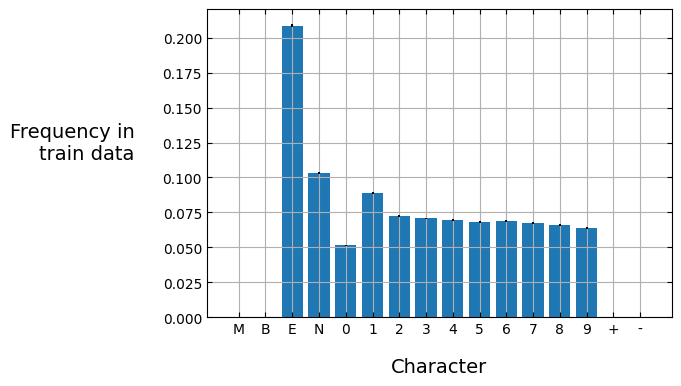

In [7]:
##=========================================================##
##   Quickly visualise distribution of token frequencies   ##
##=========================================================##

##  Imports
import numpy as np
from matplotlib import pyplot as plt

##  Get sample of train data labels
train_data_sample = np.concatenate([train_gen[i][1].numpy().flatten() for i in range(1000)])

##  Ignore masked tokens
train_data_sample = train_data_sample[train_data_sample != 0]

##  Count number for each token
chars, freqs = [], []
for token, char in train_gen.token_transform.detokeniser_dict.items() :
    chars.append(char)
    freqs.append(len(train_data_sample[train_data_sample==token]))
    
##  Normalise counts to frequency
freqs     = np.array(freqs).astype(np.float32)
freqs_err = np.sqrt(freqs)
freqs_tot = np.sum(freqs)
freqs     /= freqs_tot
freqs_err /= freqs_tot

##  Log token frequencies
for char, freq, freq_err in zip(chars, freqs, freqs_err) :
    logger.debug(f"Token '{char}' in training data with frequency {100.*freq:.1f} +- {100.*freq_err:.1f} % (masked)")

##  Plot quick bar chart of frequencies
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_subplot(1, 1, 1)
ax.tick_params(which="both", axis="both", right=True, top=True, labelsize=10, direction="in")
ax.grid()
ax.set_xlabel("Character", fontsize=14, va="top"  , labelpad=15)
ax.set_ylabel("Frequency in\ntrain data", fontsize=14, ha="right", rotation=0, labelpad=20)

ax.bar(chars, freqs, yerr=freqs_err)

fig_fname = f"{working_dir}/token_distribution.pdf"
logger.info(f"Saving distribution of token frequencies to file {fig_fname}")

plt.savefig(fig_fname, bbox_inches="tight")
plt.show(fig)
plt.close(fig)


##  4.  Create model

Create the keras model object that handles sequence-sequence transformations from alread-tokenised data

In [8]:

from tensorflow.keras.layers     import Add, Average, Concatenate, Embedding, Input, LayerNormalization
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam

from mathsformer.tf_objects import (DecoderBlock, EncoderBlock, Enumerate, FeedForwardBlock, LearnableMixture, MaskedCategoricalAccuracy,
                                    MaskedSparseCategoricalCrossentropy, PositionalEncoding)
from mathsformer.tf_objects import scalar_masked_sparse_categorical_crossentropy, scalar_masked_categorical_accuracy


In [9]:
'''
class GradientFlowEncoder(EncoderBlock) :
    def __init__(self, *args, **kwargs) :
        super().__init__(*args, **kwargs)
        
    def build(self, x) :
        self._weight = self.add_weight(f"{self.name}_weight", 
                                       shape=(1,), 
                                       initializer=tf.constant_initializer(0.01), 
                                       trainable=True, 
                                       dtype=self.dtype)
        
    def call(self, x, mask=None) :
                        
        with tf.GradientTape() as tape :
            tape.watch(x)
            y = super().call(x, mask=mask)
            y = tf.reduce_sum(y, axis=-1)
            y = tf.reduce_sum(y, axis=-1)
            y = tf.nn.sigmoid(y)
            y = y[..., tf.newaxis]
            
        div = tape.batch_jacobian(y, x)
        div = div[:,0,:,:]       
        lam = tf.nn.sigmoid(self._weight)
        return x - lam*div
    '''

'\nclass GradientFlowEncoder(EncoderBlock) :\n    def __init__(self, *args, **kwargs) :\n        super().__init__(*args, **kwargs)\n        \n    def build(self, x) :\n        self._weight = self.add_weight(f"{self.name}_weight", \n                                       shape=(1,), \n                                       initializer=tf.constant_initializer(0.01), \n                                       trainable=True, \n                                       dtype=self.dtype)\n        \n    def call(self, x, mask=None) :\n                        \n        with tf.GradientTape() as tape :\n            tape.watch(x)\n            y = super().call(x, mask=mask)\n            y = tf.reduce_sum(y, axis=-1)\n            y = tf.reduce_sum(y, axis=-1)\n            y = tf.nn.sigmoid(y)\n            y = y[..., tf.newaxis]\n            \n        div = tape.batch_jacobian(y, x)\n        div = div[:,0,:,:]       \n        lam = tf.nn.sigmoid(self._weight)\n        return x - lam*div\n    '

In [10]:

def create_text_to_text_model(vocab_length:int, 
                              name:str, 
                              do_compile:bool       = True,
                              use_old_loss:bool     = False,
                              dtype_in              = tf.int32, 
                              dtype                 = tf.float32, 
                              dropout:float         = 0.1, 
                              jit_compile:bool      = None,
                              optimizer             = Adam,
                              optimizer_args:dict   = None,
                              idempotent_size:int   = 1,
                              pos_enc_num_freqs:int = 32, pos_enc_min_period:float = 4, pos_enc_max_period:float = 500 , pos_enc_learnable:bool = False,
                              ndim_embedding:int          = 64, comb_type:str                = "average",
                              num_encoder_blocks:int      = 5 , ndim_encoder:int             = 64 , skip_connect_encoder:bool  = True,
                              num_decoder_blocks:int      = 5 , ndim_decoder:int             = 64 , skip_connect_decoder:bool  = True,
                              num_heads_encoder:int       = 8 , ndim_att_hidden_encoder:int  = 128, ndim_ff_hidden_encoder:int = 128, 
                              num_heads_decoder:int       = 8 , ndim_att_hidden_decoder:int  = 128, ndim_ff_hidden_decoder:int = 128, 
                              num_encoder_loops:int       = 1 , num_decoder_loops:int        = 1  ,
                              num_post_layers_decoder:int = 3 , ndim_post_layers_decoder:int = 512, 
                             ) :
    """
    """
    ##  Resolve mutable default args
    if optimizer_args is None :
        optimizer_args = {'learning_rate': 1e-3}
    
    ##=============================================##
    ##===   Input layer - Output shape [B, S]   ===##
    ##=============================================##
    x_in_enc = Input((None,), dtype=dtype_in, name=f"{name}_encoder_input_layer")
    x_in_dec = Input((None,), dtype=dtype_in, name=f"{name}_decoder_input_layer")
            
    ##===========================================================================##
    ##===  Token embedding, masking 0s - Output shape [B, S, ndim_embedding]  ===##
    ##===========================================================================##
    x_embed_enc = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_encoder_embedding")(x_in_enc)
    x_embed_dec = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_decoder_embedding")(x_in_dec)
    
    ##=========================================================================##
    ##===  Enumerate indices for positional encoding - Output shape [B, S]  ===##
    ##=========================================================================##
    x_pos_enc = Enumerate(name=f"{name}_encoder_enumerate", dtype=dtype)(x_in_enc, minimal_dims=False)
    x_pos_dec = Enumerate(name=f"{name}_decoder_enumerate", dtype=dtype)(x_in_dec, minimal_dims=False)
    
    ##========================================================================##
    ##===  Positional encoding - Output shape [B, S, 2*pos_enc_num_freqs]  ===##
    ##========================================================================##
    x_pos_enc = PositionalEncoding(num_freqs  = pos_enc_num_freqs, 
                                   min_period = pos_enc_min_period, 
                                   max_period = pos_enc_max_period, 
                                   learnable  = pos_enc_learnable,
                                   dtype      = dtype, 
                                   name       = f"{name}_encoder_position_encoding")(x_pos_enc)
    x_pos_dec = PositionalEncoding(num_freqs  = pos_enc_num_freqs, 
                                   min_period = pos_enc_min_period, 
                                   max_period = pos_enc_max_period, 
                                   learnable  = pos_enc_learnable,
                                   dtype      = dtype, 
                                   name       = f"{name}_decoder_position_encoding")(x_pos_dec)

    ##==============================================================================================##
    ##===  Combine embeddings end pos enc - Output shape [B, S, N] where N depends on comb_type  ===##
    ##==============================================================================================##
    allowed_comb_types = ["add", "sum", "average", "mean", "concat", "concatenate", "mixture"]
    match comb_type.lower() :
        case "add" | "sum" :
            x_enc = Add(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Add(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "average" | "mean" :
            x_enc = Average(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Average(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "concat" | "concatenate" :
            x_enc = Concatenate(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Concatenate(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "mixture" :
            x_enc = LearnableMixture(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = LearnableMixture(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case _ :
            raise RuntimeError(f"comb_type '{comb_type}' not recognised, recognised keywords are {allowed_comb_types}")
    
    ##============================================================##
    ##===  Encoder blocks - Output shape [B, S, ndim_encoder]  ===##
    ##============================================================##
    encoder_blocks = []
    for layer_idx in range(num_encoder_blocks) :
        encoder_blocks.append(EncoderBlock(
                                 ndim_encoder, 
                                 num_heads_encoder, 
                                 ndim_att_hidden_encoder, 
                                 ndim_ff_hidden_encoder, 
                                 dropout_mha     = dropout, 
                                 dtype           = dtype, 
                                 pre_layer_norm  = True, 
                                 post_layer_norm = False, 
                                 skip_connect    = skip_connect_encoder, 
                                 name            = f"{name}_encoder_block_{layer_idx+1}"))
        
    for loop_idx in range(num_encoder_loops) :
        for encoder_block in encoder_blocks :
            x_enc = encoder_block(x_enc)
    x_enc = LayerNormalization(name=f"{name}_encoder_output_norm")(x_enc)
           
    x_post_enc = x_enc
    for loop_idx in range(idempotent_size) :
        for encoder_block in encoder_blocks :
            x_post_enc = encoder_block(x_post_enc)
    x_post_enc = LayerNormalization(name=f"{name}_encoder_idem_output_norm")(x_post_enc)
    
    ##============================================================##
    ##===  Decoder blocks - Output shape [B, S, ndim_decoder]  ===##
    ##============================================================##
    decoder_blocks = []
    for layer_idx in range(num_decoder_blocks) :
        decoder_blocks.append(DecoderBlock(
                                 ndim_decoder, 
                                 num_heads_decoder, 
                                 ndim_att_hidden_decoder, 
                                 ndim_ff_hidden_decoder, 
                                 dropout_mha     = dropout, 
                                 dtype           = dtype, 
                                 pre_layer_norm  = True, 
                                 post_layer_norm = False, 
                                 skip_connect    = skip_connect_decoder, 
                                 name            = f"{name}_decoder_block_{layer_idx+1}"))
        
    x_post_dec = x_dec
    for loop_idx in range(num_decoder_loops) :
        for decoder_block in decoder_blocks :
            x_dec      = decoder_block([x_dec, x_enc])
            x_post_dec = decoder_block([x_post_dec, x_post_enc])
        
    ##==================================================================================================##
    ##===  Predict logit probabilities using feed-forward block - Output shape [B, S, vocab_length]  ===##
    ##==================================================================================================##
    ##  - use layer_norm instead of batch_norm because elements in sequence are not independent
    ff_block = FeedForwardBlock(vocab_length, 
                         ndim_hidden       = ndim_post_layers_decoder, 
                         num_hidden_layers = num_post_layers_decoder, 
                         skip_connect      = False, 
                         pre_layer_norm    = True, 
                         post_layer_norm   = False, 
                         batch_norm        = False, 
                         dtype             = dtype, 
                         name              = f"{name}_output")
    x, x2 = ff_block(x_dec), ff_block(x_post_dec)
    
    ##  Create model
    if idempotent_size > 0 :
        model = Model([x_in_enc, x_in_dec], [x, x2], name=name)
    else :
        model = Model([x_in_enc, x_in_dec], x, name=name)
    
    ##  Compile model with sparse categorical crossentropy loss and accuracy metric
    if do_compile :
        acc  = MaskedCategoricalAccuracy(scalar_output=True, equal_token_weight=True, use_keras_mask=False, mask_value=0)
        loss = MaskedSparseCategoricalCrossentropy(scalar_output=True, equal_token_weight=True, use_keras_mask=False, mask_value=0, from_logits=True)
        model.compile(loss        = loss, 
                      optimizer   = optimizer(**optimizer_args), 
                      metrics     = [acc],
                      jit_compile = jit_compile)
    
    ##  Return model
    return model


In [11]:
def create_text_to_text_model_from_config(cfg_model, token_transform) :
    """
    Create a text-to-text transformer model
    
    Inputs:
    
        >  cfg_model, Config
           Model configuration
           
        >  token_transform, TokenTransform
           Tokeniser
    """
    return create_text_to_text_model(
                          vocab_length                = token_transform.vocab_length, 
                          name                        = cfg_model["name"],
                          do_compile                  = True,
                          use_old_loss                = cfg_model["use_old_loss"],
                          dtype_in                    = token_transform.dtype,
                          dtype                       = cfg_model["dtype"],
                          dropout                     = cfg_model["dropout"],
                          jit_compile                 = cfg_model["jit_compile"],
                          optimizer                   = cfg_model.get("optimizer", Adam),
                          optimizer_args              = cfg_model.get("optimizer_args", {}),
                          idempotent_size             = cfg_model["idempotent_size"],
                          pos_enc_num_freqs           = cfg_model["positional_encoding"]["num_freqs"],
                          pos_enc_min_period          = cfg_model["positional_encoding"]["min_period"],
                          pos_enc_max_period          = cfg_model["positional_encoding"]["max_period"],
                          pos_enc_learnable           = cfg_model["positional_encoding"]["learnable"],
                          ndim_embedding              = cfg_model["ndim_embedding"],
                          num_encoder_blocks          = cfg_model["encoder"]["num_blocks"],
                          num_encoder_loops           = cfg_model["encoder"]["num_loops"],
                          ndim_encoder                = cfg_model["encoder"]["ndim"],
                          num_heads_encoder           = cfg_model["encoder"]["num_heads"],
                          ndim_att_hidden_encoder     = cfg_model["encoder"]["ndim_att_hidden"],
                          ndim_ff_hidden_encoder      = cfg_model["encoder"]["ndim_ff_hidden"],
                          skip_connect_encoder        = cfg_model["encoder"]["skip_connect"],
                          num_decoder_blocks          = cfg_model["decoder"]["num_blocks"],
                          num_decoder_loops           = cfg_model["decoder"]["num_loops"],
                          ndim_decoder                = cfg_model["decoder"]["ndim"],
                          num_heads_decoder           = cfg_model["decoder"]["num_heads"],
                          ndim_att_hidden_decoder     = cfg_model["decoder"]["ndim_att_hidden"],
                          ndim_ff_hidden_decoder      = cfg_model["decoder"]["ndim_ff_hidden"],
                          skip_connect_decoder        = cfg_model["decoder"]["skip_connect"],
                          num_post_layers_decoder     = cfg_model["post_decoder"]["num_layers"],
                          ndim_post_layers_decoder    = cfg_model["post_decoder"]["ndim"],)

In [12]:
##===================================================##
##   Load or create self-supervised learning model   ##
##===================================================##

##  Get filename for load model
fname = cfg_model.get("load_pretrained_model", None)

##  Load model if fname is not None, otherwise create from scratch
if fname is not None :
    logger.info   (f"Loading model from: {fname}")
    logger.warning("Loading a pretrained model will disregard model config!")
    model = backend.load_text_to_text_model(fname)
    model.optimizer.learning_rate.assign(cfg_model["optimizer_args"]["learning_rate"])  ## Reset LR to config value
else :
    logger.info(f"Creating new text-to-text model")
    model = create_text_to_text_model_from_config(cfg_model, token_transform)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

##  Print model summary
logger.info("Model created with summary:")
for s in model_summary : logger.info(s)
    
##  Print optimizer summary
logger.info(f"Optimizer is {model.optimizer}")
if hasattr(model.optimizer, "learning_rate") : logger.info(f"Learning rate is {model.optimizer.learning_rate}")
if hasattr(model.optimizer, "weight_decay" ) : logger.info(f"Weight decay is {model.optimizer.weight_decay}")


   INFO <module>: Creating new text-to-text model


   INFO <module>: Model created with summary:


INFO:mathsformer:Model created with summary:


   INFO <module>: Model: "mathsformer_LLM"


INFO:mathsformer:Model: "mathsformer_LLM"


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     


INFO:mathsformer: Layer (type)                   Output Shape         Param #     Connected to                     


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_positi  (None, None, 128)   64          ['mathsformer_LLM_encoder_enumera


INFO:mathsformer: mathsformer_LLM_encoder_positi  (None, None, 128)   64          ['mathsformer_LLM_encoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_encoder_embeddi


INFO:mathsformer: mathsformer_LLM_encoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_encoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_encoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_emb_and


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_emb_and


   INFO <module>:  1 (EncoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (EncoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [0][0]',                         


INFO:mathsformer:                                                                 [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [3][0]']                         


INFO:mathsformer:                                                                 [3][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_block_1


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_block_1


   INFO <module>:  2 (EncoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (EncoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [4][0]']                         


INFO:mathsformer:                                                                 [4][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_positi  (None, None, 128)   64          ['mathsformer_LLM_decoder_enumera


INFO:mathsformer: mathsformer_LLM_decoder_positi  (None, None, 128)   64          ['mathsformer_LLM_decoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_decoder_embeddi


INFO:mathsformer: mathsformer_LLM_decoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_decoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_decoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_output  (None, None, 128)   256         ['mathsformer_LLM_encoder_block_2


INFO:mathsformer: mathsformer_LLM_encoder_output  (None, None, 128)   256         ['mathsformer_LLM_encoder_block_2


   INFO <module>:  _norm (LayerNormalization)                                      [4][0]']                         


INFO:mathsformer: _norm (LayerNormalization)                                      [4][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_emb_and


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_emb_and


   INFO <module>:  1 (DecoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (DecoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_output_


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_output_


   INFO <module>:                                                                  norm[0][0]']                     


INFO:mathsformer:                                                                 norm[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_block_1


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_block_1


   INFO <module>:  2 (DecoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (DecoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_output_


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_output_


   INFO <module>:                                                                  norm[0][0]']                     


INFO:mathsformer:                                                                 norm[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_output (FeedFo  (None, None, 16)    599824      ['mathsformer_LLM_decoder_block_2


INFO:mathsformer: mathsformer_LLM_output (FeedFo  (None, None, 16)    599824      ['mathsformer_LLM_decoder_block_2


   INFO <module>:  rwardBlock)                                                     [0][0]']                         


INFO:mathsformer: rwardBlock)                                                     [0][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>: Total params: 4,298,640


INFO:mathsformer:Total params: 4,298,640


   INFO <module>: Trainable params: 4,298,640


INFO:mathsformer:Trainable params: 4,298,640


   INFO <module>: Non-trainable params: 0


INFO:mathsformer:Non-trainable params: 0


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>: Optimizer is <keras.optimizers.adamw.AdamW object at 0x17954b550>


INFO:mathsformer:Optimizer is <keras.optimizers.adamw.AdamW object at 0x17954b550>


   INFO <module>: Learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


INFO:mathsformer:Learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


   INFO <module>: Weight decay is 0.02


INFO:mathsformer:Weight decay is 0.02


In [13]:
##==============================================================##
##   Create transformer wrapper for model and token_transform   ##
##==============================================================##

transformer = transformers.Transformer_Text_to_Text(model, token_transform)


In [14]:
##=========================================##
##   Test transformer on data generators   ##
##=========================================##

backend.test_transformer(transformer, train_gen, val_gen, test_gen, negative_char=negative_char)


   INFO test_transformer: Running text --> text mathsformer inference on some training data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:


   INFO print_predictions_table: ----------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:----------------------------------------------------------------------------------------


   INFO print_predictions_table:                 INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ----------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:----------------------------------------------------------------------------------------


   INFO print_predictions_table:               N901+87         N814       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:              N901+87         N814       000330 B0003300000707                      ?   


   INFO print_predictions_table:                  N490         N490       000330 B0003300000700                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                 N490         N490       000330 B0003300000700                      ?   


   INFO print_predictions_table:                N169-9         N178       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:               N169-9         N178       000330 B0003300000707                      ?   


   INFO print_predictions_table:                  N875         N875       000330 B0003300000700                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                 N875         N875       000330 B0003300000700                      ?   


   INFO print_predictions_table:        N6-283-555+N45         N889       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       N6-283-555+N45         N889       000330 B0003300000707                      ?   


   INFO print_predictions_table:                N63-N7          N56       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:               N63-N7          N56       000330 B0003300000707                      ?   


   INFO print_predictions_table:              N469-N83         N386       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:             N469-N83         N386       000330 B0003300000707                      ?   


   INFO print_predictions_table:  9510-N36+1500+6537-3        17580       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 9510-N36+1500+6537-3        17580       000330 B0003300000707                      ?   


   INFO print_predictions_table:               63+2517         2580       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:              63+2517         2580       000330 B0003300000707                      ?   


   INFO print_predictions_table:            N374-N9949         9575       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:           N374-N9949         9575       000330 B0003300000707                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some validation data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some validation data:


   INFO print_predictions_table: ---------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------


   INFO print_predictions_table:          INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:         INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ---------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------


   INFO print_predictions_table:   3-N3988+N847         3144        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  3-N3988+N847         3144        00033 B0003300000707                      ?   


   INFO print_predictions_table:      7797+5-N4         7806        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     7797+5-N4         7806        00033 B0003300000707                      ?   


   INFO print_predictions_table:   N8357-N11+N7        N8353        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N8357-N11+N7        N8353        00033 B0003300000707                      ?   


   INFO print_predictions_table:  6686-N437-236         6887        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 6686-N437-236         6887        00033 B0003300000707                      ?   


   INFO print_predictions_table:      N5+4442+8         4445        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     N5+4442+8         4445        00033 B0003300000707                      ?   


   INFO print_predictions_table:    2123-N1+N68         2056        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   2123-N1+N68         2056        00033 B0003300000707                      ?   


   INFO print_predictions_table:    95+4563+879         5537        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   95+4563+879         5537        00033 B0003300000707                      ?   


   INFO print_predictions_table:   1639+N2868+5        N1224        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  1639+N2868+5        N1224        00033 B0003300000707                      ?   


   INFO print_predictions_table:       8+N725-3         N720        00033 B00033000007B7                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:      8+N725-3         N720        00033 B00033000007B7                      ?   


   INFO print_predictions_table:  N283+N962-N40        N1205        00033 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N283+N962-N40        N1205        00033 B0003300000707                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some test data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some test data:


   INFO print_predictions_table: -----------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:-----------------------------------------------------------------------------------------------


   INFO print_predictions_table:                        INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                       INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: -----------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:-----------------------------------------------------------------------------------------------


   INFO print_predictions_table:  N6774-N71+5814-6016+45+N976        N7836       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N6774-N71+5814-6016+45+N976        N7836       000330 B0003300000707                      ?   


   INFO print_predictions_table:        N5489-65-65-N1+7-N734        N4877       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       N5489-65-65-N1+7-N734        N4877       000330 B0003300000707                      ?   


   INFO print_predictions_table:        N3-79+43-890+N3666-N6        N4589       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       N3-79+43-890+N3666-N6        N4589       000330 B0003300000707                      ?   


   INFO print_predictions_table:     N950+189+2766-N594+474-1         3072       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N950+189+2766-N594+474-1         3072       000330 B0003300000707                      ?   


   INFO print_predictions_table:     N3994+N9+5718-N4-6+N9512        N7799       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N3994+N9+5718-N4-6+N9512        N7799       000330 B0003300000707                      ?   


   INFO print_predictions_table:   N742+8580+45+N52-N1561-N84         9476       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N742+8580+45+N52-N1561-N84         9476       000330 B0003300000707                      ?   


   INFO print_predictions_table:    3524-2067-3915+N252+N1-82        N2793       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   3524-2067-3915+N252+N1-82        N2793       000330 B0003300000707                      ?   


   INFO print_predictions_table:   220-N665-74-N42-N415+N9861        N8593       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  220-N665-74-N42-N415+N9861        N8593       000330 B0003300000707                      ?   


   INFO print_predictions_table:     N8355-N5-N97+317-N755+85        N7096       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N8355-N5-N97+317-N755+85        N7096       000330 B0003300000707                      ?   


   INFO print_predictions_table:    5769+6-9703-N6918-738+N48         2204       000330 B0003300000707                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   5769+6-9703-N6918-738+N48         2204       000330 B0003300000707                      ?   


##  5.  Train model

In [15]:
##===================================##
##   Create callbacks for training   ##
##===================================##

callbacks = backend.get_callbacks(cfg_training, working_dir, transformer=transformer, train_gen=train_gen_reproducible, 
                                  val_gen=val_gen, negative_char=negative_char)


   INFO get_callbacks: Registered training callback: LoggerCallback with loglvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LoggerCallback with loglvl=10


   INFO get_callbacks: Registered training callback: AdaptiveLearningRate with decay_factor=0.2, patience=3, monitor=loss, mode=min, log_lvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: AdaptiveLearningRate with decay_factor=0.2, patience=3, monitor=loss, mode=min, log_lvl=10


   INFO get_callbacks: Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idemm1_2023_06_25_v2/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idemm1_2023_06_25_v2/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


   INFO get_callbacks: Registered training callback: LayerWeightsRecord with batch_frequency=2000, recursive=True


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LayerWeightsRecord with batch_frequency=2000, recursive=True


   INFO get_callbacks: Registered training callback: LambdaCallback for test_transformer with num_print=10, negative_char='N'


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LambdaCallback for test_transformer with num_print=10, negative_char='N'


In [ ]:
##=================##
##   Train model   ##
##=================##

do_train = cfg_training.get("train", True)

if do_train :
    max_epochs = cfg_training["max_epochs"]
    logger.info(f"Begin model training with max_epochs={max_epochs}")
    model.fit(train_gen, 
              epochs          = max_epochs,
              validation_data = val_gen,
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO <module>: Begin model training with max_epochs=100000


INFO:mathsformer:Begin model training with max_epochs=100000
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Setting variable to learning_rate:0


Epoch 1/100000


2023-06-25 21:02:16.707762: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2000/2000 [==============================] - ETA: 0s - loss: 1.8261 - masked_categorical_accuracy: 0.3637

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 0
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.8261
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.36374
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.9656
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.32839
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.se

2000/2000 [==============================] - 757s 374ms/step - loss: 1.8261 - masked_categorical_accuracy: 0.3637 - val_loss: 1.9656 - val_masked_categorical_accuracy: 0.3284
Epoch 2/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.5140 - masked_categorical_accuracy: 0.4591

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 1
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.514
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.45906
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.7925
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.3725
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.self

2000/2000 [==============================] - 745s 372ms/step - loss: 1.5140 - masked_categorical_accuracy: 0.4591 - val_loss: 1.7925 - val_masked_categorical_accuracy: 0.3725
Epoch 3/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.3671 - masked_categorical_accuracy: 0.5122

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 2
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.3671
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.51221
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.7104
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.39211
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.se

2000/2000 [==============================] - 741s 370ms/step - loss: 1.3671 - masked_categorical_accuracy: 0.5122 - val_loss: 1.7104 - val_masked_categorical_accuracy: 0.3921
Epoch 4/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.3188 - masked_categorical_accuracy: 0.5246

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 3
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.3188
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.52456
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.5968
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.42711
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.se

2000/2000 [==============================] - 721s 360ms/step - loss: 1.3188 - masked_categorical_accuracy: 0.5246 - val_loss: 1.5968 - val_masked_categorical_accuracy: 0.4271
Epoch 5/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.2453 - masked_categorical_accuracy: 0.5448

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 4
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.2453
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.54477
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.4939
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.45366
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.se

2000/2000 [==============================] - 724s 362ms/step - loss: 1.2453 - masked_categorical_accuracy: 0.5448 - val_loss: 1.4939 - val_masked_categorical_accuracy: 0.4537
Epoch 6/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.1721 - masked_categorical_accuracy: 0.5647

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 5
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.1721
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.56466
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.3806
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.47746
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.se

2000/2000 [==============================] - 725s 363ms/step - loss: 1.1721 - masked_categorical_accuracy: 0.5647 - val_loss: 1.3806 - val_masked_categorical_accuracy: 0.4775
Epoch 7/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.1110 - masked_categorical_accuracy: 0.5802

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 6
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.111
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.5802
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.3199
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.50431
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.self

2000/2000 [==============================] - 745s 372ms/step - loss: 1.1110 - masked_categorical_accuracy: 0.5802 - val_loss: 1.3199 - val_masked_categorical_accuracy: 0.5043
Epoch 8/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.0596 - masked_categorical_accuracy: 0.5973

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 7
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.0596
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.59734
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.2773
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.51465
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.se

2000/2000 [==============================] - 741s 370ms/step - loss: 1.0596 - masked_categorical_accuracy: 0.5973 - val_loss: 1.2773 - val_masked_categorical_accuracy: 0.5147
Epoch 9/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.0209 - masked_categorical_accuracy: 0.6105

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 8
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.0209
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.61046
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.2282
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.5306
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.sel

2000/2000 [==============================] - 753s 377ms/step - loss: 1.0209 - masked_categorical_accuracy: 0.6105 - val_loss: 1.2282 - val_masked_categorical_accuracy: 0.5306
Epoch 10/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.9846 - masked_categorical_accuracy: 0.6234

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 9
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.98457
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.6234
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.1902
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.5456
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.sel

2000/2000 [==============================] - 739s 370ms/step - loss: 0.9846 - masked_categorical_accuracy: 0.6234 - val_loss: 1.1902 - val_masked_categorical_accuracy: 0.5456
Epoch 11/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.9388 - masked_categorical_accuracy: 0.6414

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 10
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.93884
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.64136
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.1563
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.56755
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 730s 365ms/step - loss: 0.9388 - masked_categorical_accuracy: 0.6414 - val_loss: 1.1563 - val_masked_categorical_accuracy: 0.5675
Epoch 12/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.8797 - masked_categorical_accuracy: 0.6627

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 11
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.87974
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.66266
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.1512
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.59474
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 724s 362ms/step - loss: 0.8797 - masked_categorical_accuracy: 0.6627 - val_loss: 1.1512 - val_masked_categorical_accuracy: 0.5947
Epoch 13/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.8233 - masked_categorical_accuracy: 0.6832

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 12
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.82331
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.6832
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.2039
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.59848
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.s

2000/2000 [==============================] - 723s 362ms/step - loss: 0.8233 - masked_categorical_accuracy: 0.6832 - val_loss: 1.2039 - val_masked_categorical_accuracy: 0.5985
Epoch 14/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.8009 - masked_categorical_accuracy: 0.6924

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 13
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.80087
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.69235
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.172
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.59029
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.s

2000/2000 [==============================] - 730s 365ms/step - loss: 0.8009 - masked_categorical_accuracy: 0.6924 - val_loss: 1.1720 - val_masked_categorical_accuracy: 0.5903
Epoch 15/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.7679 - masked_categorical_accuracy: 0.7050

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 14
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.76795
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.70497
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.0962
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.61396
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 739s 369ms/step - loss: 0.7679 - masked_categorical_accuracy: 0.7050 - val_loss: 1.0962 - val_masked_categorical_accuracy: 0.6140
Epoch 16/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.7625 - masked_categorical_accuracy: 0.7077

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 15
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.76252
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.7077
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.0973
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.61787
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.s

2000/2000 [==============================] - 749s 374ms/step - loss: 0.7625 - masked_categorical_accuracy: 0.7077 - val_loss: 1.0973 - val_masked_categorical_accuracy: 0.6179
Epoch 17/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.7378 - masked_categorical_accuracy: 0.7169

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 16
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.73782
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.71689
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.0664
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.6173
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.s

2000/2000 [==============================] - 746s 373ms/step - loss: 0.7378 - masked_categorical_accuracy: 0.7169 - val_loss: 1.0664 - val_masked_categorical_accuracy: 0.6173
Epoch 18/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.7314 - masked_categorical_accuracy: 0.7210

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 17
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.73138
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.72097
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.0291
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.6361
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.s

2000/2000 [==============================] - 742s 371ms/step - loss: 0.7314 - masked_categorical_accuracy: 0.7210 - val_loss: 1.0291 - val_masked_categorical_accuracy: 0.6361
Epoch 19/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.7037 - masked_categorical_accuracy: 0.7298

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 18
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.70367
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.72976
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.1056
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.64867
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 728s 364ms/step - loss: 0.7037 - masked_categorical_accuracy: 0.7298 - val_loss: 1.1056 - val_masked_categorical_accuracy: 0.6487
Epoch 20/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6897 - masked_categorical_accuracy: 0.7345

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 19
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.68967
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.73449
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.9938
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.65188
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 724s 362ms/step - loss: 0.6897 - masked_categorical_accuracy: 0.7345 - val_loss: 0.9938 - val_masked_categorical_accuracy: 0.6519
Epoch 21/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6853 - masked_categorical_accuracy: 0.7374

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 20
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.68527
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.73738
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.0185
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.65407
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 722s 361ms/step - loss: 0.6853 - masked_categorical_accuracy: 0.7374 - val_loss: 1.0185 - val_masked_categorical_accuracy: 0.6541
Epoch 22/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6791 - masked_categorical_accuracy: 0.7408

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 21
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.67913
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.74081
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.95937
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.65933
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 727s 363ms/step - loss: 0.6791 - masked_categorical_accuracy: 0.7408 - val_loss: 0.9594 - val_masked_categorical_accuracy: 0.6593
Epoch 23/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6604 - masked_categorical_accuracy: 0.7455

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 22
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.66037
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.74555
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 1.0533
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.65767
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 735s 367ms/step - loss: 0.6604 - masked_categorical_accuracy: 0.7455 - val_loss: 1.0533 - val_masked_categorical_accuracy: 0.6577
Epoch 24/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6498 - masked_categorical_accuracy: 0.7498

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 23
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.64979
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.74978
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.94201
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.66479
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 736s 368ms/step - loss: 0.6498 - masked_categorical_accuracy: 0.7498 - val_loss: 0.9420 - val_masked_categorical_accuracy: 0.6648
Epoch 25/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6382 - masked_categorical_accuracy: 0.7540

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 24
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.63823
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.75402
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.91876
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.68454
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 742s 371ms/step - loss: 0.6382 - masked_categorical_accuracy: 0.7540 - val_loss: 0.9188 - val_masked_categorical_accuracy: 0.6845
Epoch 26/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6370 - masked_categorical_accuracy: 0.7557

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 25
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.63704
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.75565
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.95741
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.69139
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 738s 369ms/step - loss: 0.6370 - masked_categorical_accuracy: 0.7557 - val_loss: 0.9574 - val_masked_categorical_accuracy: 0.6914
Epoch 27/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6295 - masked_categorical_accuracy: 0.7592

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 26
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.62954
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.7592
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.789
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.70994
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.se

2000/2000 [==============================] - 731s 365ms/step - loss: 0.6295 - masked_categorical_accuracy: 0.7592 - val_loss: 0.7890 - val_masked_categorical_accuracy: 0.7099
Epoch 28/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6164 - masked_categorical_accuracy: 0.7627

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 27
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.6164
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.76271
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.78096
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.71799
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 722s 361ms/step - loss: 0.6164 - masked_categorical_accuracy: 0.7627 - val_loss: 0.7810 - val_masked_categorical_accuracy: 0.7180
Epoch 29/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6062 - masked_categorical_accuracy: 0.7672

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 28
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.60622
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.76722
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.77865
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.71703
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 718s 359ms/step - loss: 0.6062 - masked_categorical_accuracy: 0.7672 - val_loss: 0.7786 - val_masked_categorical_accuracy: 0.7170
Epoch 30/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5989 - masked_categorical_accuracy: 0.7698

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 29
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.59895
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.76979
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.73082
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.72284
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 721s 360ms/step - loss: 0.5989 - masked_categorical_accuracy: 0.7698 - val_loss: 0.7308 - val_masked_categorical_accuracy: 0.7228
Epoch 31/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5890 - masked_categorical_accuracy: 0.7736

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 30
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.58903
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.77355
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.67633
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.74415
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 733s 366ms/step - loss: 0.5890 - masked_categorical_accuracy: 0.7736 - val_loss: 0.6763 - val_masked_categorical_accuracy: 0.7442
Epoch 32/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5715 - masked_categorical_accuracy: 0.7792

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 31
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.57151
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.77918
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.67638
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.74122
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 737s 368ms/step - loss: 0.5715 - masked_categorical_accuracy: 0.7792 - val_loss: 0.6764 - val_masked_categorical_accuracy: 0.7412
Epoch 33/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5622 - masked_categorical_accuracy: 0.7830

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 32
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.56221
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.78303
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.66145
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.75458
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 737s 369ms/step - loss: 0.5622 - masked_categorical_accuracy: 0.7830 - val_loss: 0.6615 - val_masked_categorical_accuracy: 0.7546
Epoch 34/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5560 - masked_categorical_accuracy: 0.7857

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 33
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.55604
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.78574
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.5771
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.78056
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 732s 366ms/step - loss: 0.5560 - masked_categorical_accuracy: 0.7857 - val_loss: 0.5771 - val_masked_categorical_accuracy: 0.7806
Epoch 35/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5230 - masked_categorical_accuracy: 0.7975

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 34
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.52303
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.79751
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.47922
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.80815
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 734s 367ms/step - loss: 0.5230 - masked_categorical_accuracy: 0.7975 - val_loss: 0.4792 - val_masked_categorical_accuracy: 0.8082
Epoch 36/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.4856 - masked_categorical_accuracy: 0.8096

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 35
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.48559
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.80958
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.38152
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.85238
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 718s 359ms/step - loss: 0.4856 - masked_categorical_accuracy: 0.8096 - val_loss: 0.3815 - val_masked_categorical_accuracy: 0.8524
Epoch 37/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.4410 - masked_categorical_accuracy: 0.8245

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 36
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.44095
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.82453
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.36515
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.85064
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 722s 361ms/step - loss: 0.4410 - masked_categorical_accuracy: 0.8245 - val_loss: 0.3652 - val_masked_categorical_accuracy: 0.8506
Epoch 38/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.4161 - masked_categorical_accuracy: 0.8338

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 37
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.41609
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.83384
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.30202
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.88368
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 714s 357ms/step - loss: 0.4161 - masked_categorical_accuracy: 0.8338 - val_loss: 0.3020 - val_masked_categorical_accuracy: 0.8837
Epoch 39/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.3845 - masked_categorical_accuracy: 0.8448

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 38
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.38448
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.84482
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.34076
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.86771
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 732s 366ms/step - loss: 0.3845 - masked_categorical_accuracy: 0.8448 - val_loss: 0.3408 - val_masked_categorical_accuracy: 0.8677
Epoch 40/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.3665 - masked_categorical_accuracy: 0.8531

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 39
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.36646
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.85312
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.27753
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.8864
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 737s 368ms/step - loss: 0.3665 - masked_categorical_accuracy: 0.8531 - val_loss: 0.2775 - val_masked_categorical_accuracy: 0.8864
Epoch 41/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.3507 - masked_categorical_accuracy: 0.8593

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 40
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.35066
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.85934
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.24674
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.90413
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 737s 369ms/step - loss: 0.3507 - masked_categorical_accuracy: 0.8593 - val_loss: 0.2467 - val_masked_categorical_accuracy: 0.9041
Epoch 42/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.3354 - masked_categorical_accuracy: 0.8657

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 41
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.33535
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.86569
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.2408
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.91009
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 735s 367ms/step - loss: 0.3354 - masked_categorical_accuracy: 0.8657 - val_loss: 0.2408 - val_masked_categorical_accuracy: 0.9101
Epoch 43/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.3142 - masked_categorical_accuracy: 0.8742

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 42
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.3142
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.87424
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.23261
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.91154
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 740s 370ms/step - loss: 0.3142 - masked_categorical_accuracy: 0.8742 - val_loss: 0.2326 - val_masked_categorical_accuracy: 0.9115
Epoch 44/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2974 - masked_categorical_accuracy: 0.8804

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 43
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.29743
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.88041
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.19574
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.93493
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 721s 361ms/step - loss: 0.2974 - masked_categorical_accuracy: 0.8804 - val_loss: 0.1957 - val_masked_categorical_accuracy: 0.9349
Epoch 45/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2894 - masked_categorical_accuracy: 0.8844

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 44
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.28942
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.88444
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.16114
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.94459
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 719s 359ms/step - loss: 0.2894 - masked_categorical_accuracy: 0.8844 - val_loss: 0.1611 - val_masked_categorical_accuracy: 0.9446
Epoch 46/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2722 - masked_categorical_accuracy: 0.8916

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 45
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.27216
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.89162
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.19183
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.93609
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 718s 359ms/step - loss: 0.2722 - masked_categorical_accuracy: 0.8916 - val_loss: 0.1918 - val_masked_categorical_accuracy: 0.9361
Epoch 47/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2681 - masked_categorical_accuracy: 0.8954

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 46
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.26808
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.89543
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.1516
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.9528
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.s

2000/2000 [==============================] - 715s 357ms/step - loss: 0.2681 - masked_categorical_accuracy: 0.8954 - val_loss: 0.1516 - val_masked_categorical_accuracy: 0.9528
Epoch 48/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2527 - masked_categorical_accuracy: 0.9013

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 47
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.25265
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.90127
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.25715
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.92375
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 727s 364ms/step - loss: 0.2527 - masked_categorical_accuracy: 0.9013 - val_loss: 0.2571 - val_masked_categorical_accuracy: 0.9238
Epoch 49/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2314 - masked_categorical_accuracy: 0.9088

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 48
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.23143
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.90875
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.14201
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.95254
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 733s 366ms/step - loss: 0.2314 - masked_categorical_accuracy: 0.9088 - val_loss: 0.1420 - val_masked_categorical_accuracy: 0.9525
Epoch 50/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2275 - masked_categorical_accuracy: 0.9115

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 49
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.22753
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.91146
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.16845
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.93959
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 733s 366ms/step - loss: 0.2275 - masked_categorical_accuracy: 0.9115 - val_loss: 0.1685 - val_masked_categorical_accuracy: 0.9396
Epoch 51/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2190 - masked_categorical_accuracy: 0.9157

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 50
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.21903
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.91574
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.50246
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.82406
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 692s 346ms/step - loss: 0.2190 - masked_categorical_accuracy: 0.9157 - val_loss: 0.5025 - val_masked_categorical_accuracy: 0.8241
Epoch 52/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2071 - masked_categorical_accuracy: 0.9198

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 51
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.20706
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.91984
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.090011
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.97063
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 640s 320ms/step - loss: 0.2071 - masked_categorical_accuracy: 0.9198 - val_loss: 0.0900 - val_masked_categorical_accuracy: 0.9706
Epoch 53/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1967 - masked_categorical_accuracy: 0.9233

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 52
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.19673
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.92334
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.12746
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.95649
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 633s 316ms/step - loss: 0.1967 - masked_categorical_accuracy: 0.9233 - val_loss: 0.1275 - val_masked_categorical_accuracy: 0.9565
Epoch 54/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2034 - masked_categorical_accuracy: 0.9233

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 53
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.20343
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.9233
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.086684
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.97334
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 621s 311ms/step - loss: 0.2034 - masked_categorical_accuracy: 0.9233 - val_loss: 0.0867 - val_masked_categorical_accuracy: 0.9733
Epoch 55/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1783 - masked_categorical_accuracy: 0.9320

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 54
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.17834
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.93196
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.092172
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.96466
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 605s 303ms/step - loss: 0.1783 - masked_categorical_accuracy: 0.9320 - val_loss: 0.0922 - val_masked_categorical_accuracy: 0.9647
Epoch 56/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1966 - masked_categorical_accuracy: 0.9276

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 55
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.19662
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.92761
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.1161
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.9561
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.s

2000/2000 [==============================] - 606s 303ms/step - loss: 0.1966 - masked_categorical_accuracy: 0.9276 - val_loss: 0.1161 - val_masked_categorical_accuracy: 0.9561
Epoch 57/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1706 - masked_categorical_accuracy: 0.9347

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 56
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.17057
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.93474
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.078265
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.9748
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 582s 291ms/step - loss: 0.1706 - masked_categorical_accuracy: 0.9347 - val_loss: 0.0783 - val_masked_categorical_accuracy: 0.9748
Epoch 58/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1739 - masked_categorical_accuracy: 0.9353

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 57
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.17393
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.93531
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.069935
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.97697
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 592s 296ms/step - loss: 0.1739 - masked_categorical_accuracy: 0.9353 - val_loss: 0.0699 - val_masked_categorical_accuracy: 0.9770
Epoch 59/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1645 - masked_categorical_accuracy: 0.9393

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 58
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.16452
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.93926
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.071146
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.97752
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 589s 294ms/step - loss: 0.1645 - masked_categorical_accuracy: 0.9393 - val_loss: 0.0711 - val_masked_categorical_accuracy: 0.9775
Epoch 60/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1559 - masked_categorical_accuracy: 0.9414

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 59
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.15594
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.94138
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.073975
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.97824
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 597s 298ms/step - loss: 0.1559 - masked_categorical_accuracy: 0.9414 - val_loss: 0.0740 - val_masked_categorical_accuracy: 0.9782
Epoch 61/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1550 - masked_categorical_accuracy: 0.9427

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 60
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.15499
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.94267
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.060391
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98091
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 599s 299ms/step - loss: 0.1550 - masked_categorical_accuracy: 0.9427 - val_loss: 0.0604 - val_masked_categorical_accuracy: 0.9809
Epoch 62/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1479 - masked_categorical_accuracy: 0.9451

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 61
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.14793
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.94506
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.041898
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98774
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 586s 293ms/step - loss: 0.1479 - masked_categorical_accuracy: 0.9451 - val_loss: 0.0419 - val_masked_categorical_accuracy: 0.9877
Epoch 63/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1386 - masked_categorical_accuracy: 0.9485

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 62
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.1386
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.94845
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.071697
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.97475
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 599s 299ms/step - loss: 0.1386 - masked_categorical_accuracy: 0.9485 - val_loss: 0.0717 - val_masked_categorical_accuracy: 0.9747
Epoch 64/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1511 - masked_categorical_accuracy: 0.9455

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 63
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.15113
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.9455
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.047363
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98467
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 595s 297ms/step - loss: 0.1511 - masked_categorical_accuracy: 0.9455 - val_loss: 0.0474 - val_masked_categorical_accuracy: 0.9847
Epoch 65/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1266 - masked_categorical_accuracy: 0.9523

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 64
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.12657
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.95231
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.053459
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98403
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 596s 298ms/step - loss: 0.1266 - masked_categorical_accuracy: 0.9523 - val_loss: 0.0535 - val_masked_categorical_accuracy: 0.9840
Epoch 66/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1307 - masked_categorical_accuracy: 0.9517

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 65
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.1307
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.95171
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.064055
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.97859
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer

2000/2000 [==============================] - 590s 295ms/step - loss: 0.1307 - masked_categorical_accuracy: 0.9517 - val_loss: 0.0641 - val_masked_categorical_accuracy: 0.9786
Epoch 67/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1244 - masked_categorical_accuracy: 0.9545

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 66
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.12444
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.95452
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.052448
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98565
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 594s 297ms/step - loss: 0.1244 - masked_categorical_accuracy: 0.9545 - val_loss: 0.0524 - val_masked_categorical_accuracy: 0.9856
Epoch 68/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1165 - masked_categorical_accuracy: 0.9571

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 67
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.11654
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.9571
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.15092
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.96109
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsformer.

2000/2000 [==============================] - 596s 298ms/step - loss: 0.1165 - masked_categorical_accuracy: 0.9571 - val_loss: 0.1509 - val_masked_categorical_accuracy: 0.9611
Epoch 69/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1141 - masked_categorical_accuracy: 0.9582

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 68
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.11406
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.95819
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.044561
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98503
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 604s 302ms/step - loss: 0.1141 - masked_categorical_accuracy: 0.9582 - val_loss: 0.0446 - val_masked_categorical_accuracy: 0.9850
Epoch 70/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1205 - masked_categorical_accuracy: 0.9572

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 69
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.12054
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.95723
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.036255
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98865
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 605s 303ms/step - loss: 0.1205 - masked_categorical_accuracy: 0.9572 - val_loss: 0.0363 - val_masked_categorical_accuracy: 0.9886
Epoch 71/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1164 - masked_categorical_accuracy: 0.9586

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 70
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.11641
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.95863
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.050632
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98212
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 596s 298ms/step - loss: 0.1164 - masked_categorical_accuracy: 0.9586 - val_loss: 0.0506 - val_masked_categorical_accuracy: 0.9821
Epoch 72/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1076 - masked_categorical_accuracy: 0.9617

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 71
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.10761
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96174
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.055771
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98325
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 589s 294ms/step - loss: 0.1076 - masked_categorical_accuracy: 0.9617 - val_loss: 0.0558 - val_masked_categorical_accuracy: 0.9832
Epoch 73/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1018 - masked_categorical_accuracy: 0.9632

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 72
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.10181
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96321
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.052729
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98265
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 600s 300ms/step - loss: 0.1018 - masked_categorical_accuracy: 0.9632 - val_loss: 0.0527 - val_masked_categorical_accuracy: 0.9827
Epoch 74/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1095 - masked_categorical_accuracy: 0.9620

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 73
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.10952
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96201
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.030067
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.99033
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 604s 302ms/step - loss: 0.1095 - masked_categorical_accuracy: 0.9620 - val_loss: 0.0301 - val_masked_categorical_accuracy: 0.9903
Epoch 75/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0943 - masked_categorical_accuracy: 0.9652

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 74
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.094349
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.9652
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.043719
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98434
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 605s 302ms/step - loss: 0.0943 - masked_categorical_accuracy: 0.9652 - val_loss: 0.0437 - val_masked_categorical_accuracy: 0.9843
Epoch 76/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0999 - masked_categorical_accuracy: 0.9644

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 75
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.099879
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96445
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.023201
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.99233
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsform

2000/2000 [==============================] - 593s 297ms/step - loss: 0.0999 - masked_categorical_accuracy: 0.9644 - val_loss: 0.0232 - val_masked_categorical_accuracy: 0.9923
Epoch 77/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0997 - masked_categorical_accuracy: 0.9651

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 76
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.09966
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96511
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.045645
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98332
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 595s 298ms/step - loss: 0.0997 - masked_categorical_accuracy: 0.9651 - val_loss: 0.0456 - val_masked_categorical_accuracy: 0.9833
Epoch 78/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0849 - masked_categorical_accuracy: 0.9696

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 77
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.084886
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96961
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.025104
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.99265
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsform

2000/2000 [==============================] - 607s 303ms/step - loss: 0.0849 - masked_categorical_accuracy: 0.9696 - val_loss: 0.0251 - val_masked_categorical_accuracy: 0.9927
Epoch 79/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1039 - masked_categorical_accuracy: 0.9643

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 78
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.10392
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96428
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.047589
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98333
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 604s 302ms/step - loss: 0.1039 - masked_categorical_accuracy: 0.9643 - val_loss: 0.0476 - val_masked_categorical_accuracy: 0.9833
Epoch 80/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0864 - masked_categorical_accuracy: 0.9691

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 79
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.086385
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96906
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.038479
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98858
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsform

2000/2000 [==============================] - 602s 301ms/step - loss: 0.0864 - masked_categorical_accuracy: 0.9691 - val_loss: 0.0385 - val_masked_categorical_accuracy: 0.9886
Epoch 81/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0838 - masked_categorical_accuracy: 0.9706

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 80
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.083771
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.9706
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.025809
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.99109
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 603s 301ms/step - loss: 0.0838 - masked_categorical_accuracy: 0.9706 - val_loss: 0.0258 - val_masked_categorical_accuracy: 0.9911
Epoch 82/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0878 - masked_categorical_accuracy: 0.9697

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 81
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.087796
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.96966
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.029909
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.99108
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsform

2000/2000 [==============================] - 591s 296ms/step - loss: 0.0878 - masked_categorical_accuracy: 0.9697 - val_loss: 0.0299 - val_masked_categorical_accuracy: 0.9911
Epoch 83/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0825 - masked_categorical_accuracy: 0.9710

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 82
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.08247
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.97098
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.032186
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98893
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 611s 306ms/step - loss: 0.0825 - masked_categorical_accuracy: 0.9710 - val_loss: 0.0322 - val_masked_categorical_accuracy: 0.9889
Epoch 84/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0803 - masked_categorical_accuracy: 0.9718

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 83
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.080336
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.97184
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.02278
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.99312
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 614s 307ms/step - loss: 0.0803 - masked_categorical_accuracy: 0.9718 - val_loss: 0.0228 - val_masked_categorical_accuracy: 0.9931
Epoch 85/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0786 - masked_categorical_accuracy: 0.9728

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 84
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.078576
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.97277
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.044343
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98606
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsform

2000/2000 [==============================] - 616s 308ms/step - loss: 0.0786 - masked_categorical_accuracy: 0.9728 - val_loss: 0.0443 - val_masked_categorical_accuracy: 0.9861
Epoch 86/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0864 - masked_categorical_accuracy: 0.9709

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 85
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.086371
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.97088
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.043711
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.98531
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsform

2000/2000 [==============================] - 622s 311ms/step - loss: 0.0864 - masked_categorical_accuracy: 0.9709 - val_loss: 0.0437 - val_masked_categorical_accuracy: 0.9853
Epoch 87/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.0698 - masked_categorical_accuracy: 0.9751

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 86
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.069785
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric masked_categorical_accuracy: 0.97513
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_loss: 0.021757
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric val_masked_categorical_accuracy: 0.9937
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:                 INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
DEBUG:mathsforme

2000/2000 [==============================] - 612s 306ms/step - loss: 0.0698 - masked_categorical_accuracy: 0.9751 - val_loss: 0.0218 - val_masked_categorical_accuracy: 0.9937
Epoch 88/100000
 575/2000 [=======>......................] - ETA: 7:07 - loss: 0.0688 - masked_categorical_accuracy: 0.9757

In [ ]:
##================##
##   Save model   ##
##================##

do_save = cfg_evaluate.get("save_model", True)

if do_save :
    save_fname = f"{working_dir}/final_model.keras"
    model.save(save_fname)
    logger.info(f"Model saved to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


## 6.  Evaluate model

In [ ]:
  
##  Find out how many datapoints to print predictions for 
num_print = cfg_evaluate.get("num_print", 20)

##  Print tables
backend.test_transformer(transformer, train_gen, val_gen, test_gen, num_print=num_print, 
                         negative_char=negative_char)


##  7. Additional visualisations

In [ ]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if cfg_evaluate["plot_weights"] :
    
    logger.info("Plotting weights")
    backend.plot_weights(callbacks, show=True, close=True, savefig=f"{working_dir}/layer_weights.pdf")
    

In [ ]:
##===============================##
##   Visualise training curves   ##
##===============================##

if cfg_evaluate["plot_training_curves"] :
    
    if not hasattr(model, "history") :
        logger.error("Cannot print training curves because no model history exists - perhaps you skipped training?")
    else :
        logger.info("Plotting training curves")
        backend.plot_training_curves(model.history.history, show=True, close=True, savefig=f"{working_dir}/training_curves.pdf")
    